<a href="https://colab.research.google.com/github/Mateo289/Signal_theory/blob/main/CVClasificacion_LFW__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [ ]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Carpeta results ya existe


# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


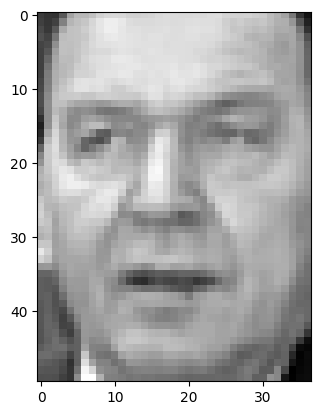

In [ ]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [ ]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

In [ ]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [ ]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]


np.float64(0.43286065070595453)

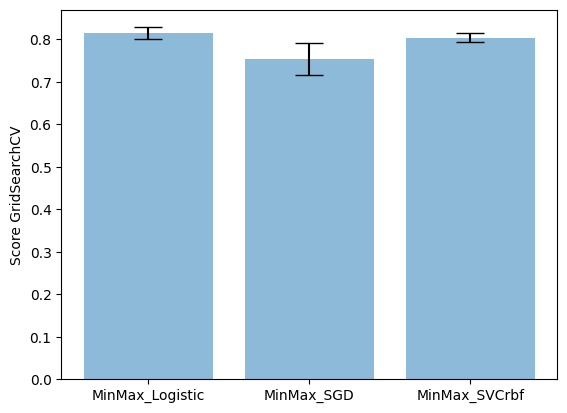

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.815 0.754 0.804]
 [0.014 0.037 0.011]]


In [ ]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

Evaluando modelo MinMax_Logistic (1/3)


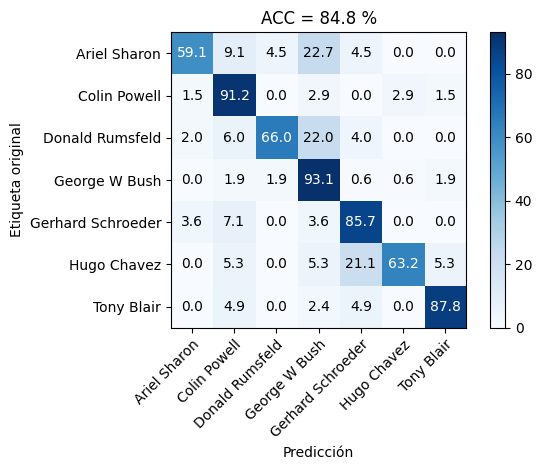

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/3)


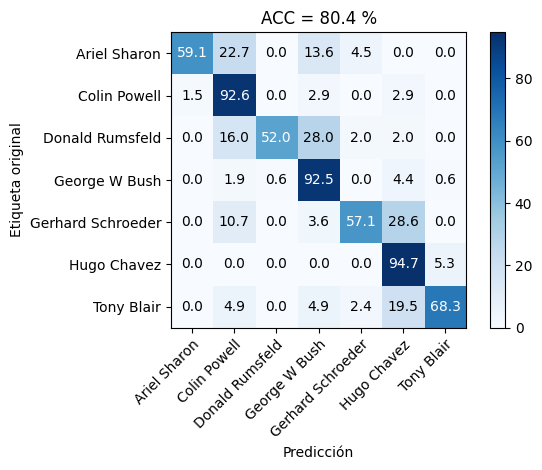

                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.59      0.72        22
     Colin Powell       0.75      0.93      0.83        68
  Donald Rumsfeld       0.96      0.52      0.68        50
    George W Bush       0.87      0.92      0.90       159
Gerhard Schroeder       0.84      0.57      0.68        28
      Hugo Chavez       0.41      0.95      0.57        19
       Tony Blair       0.93      0.68      0.79        41

         accuracy                           0.80       387
        macro avg       0.81      0.74      0.74       387
     weighted avg       0.85      0.80      0.80       387

Evaluando modelo MinMax_SVCrbf (3/3)


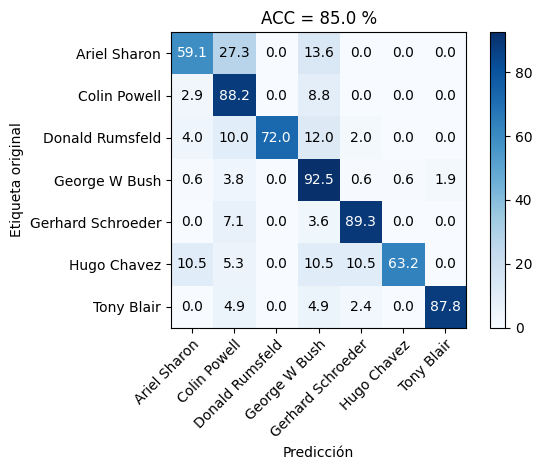

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387



In [ ]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

Evaluando modelo MinMax_Logistic (1/3)


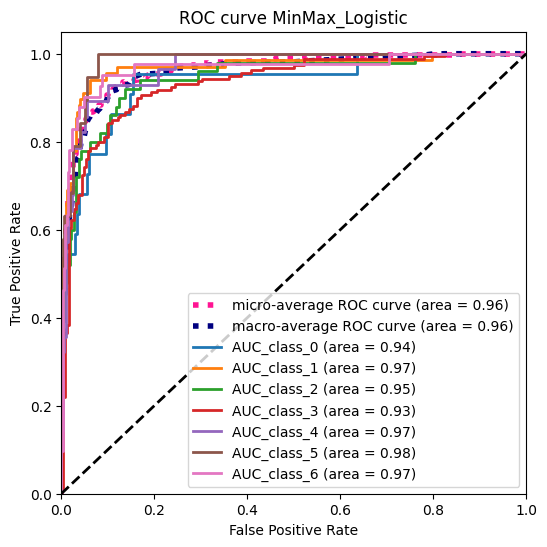

Evaluando modelo MinMax_SGD (2/3)


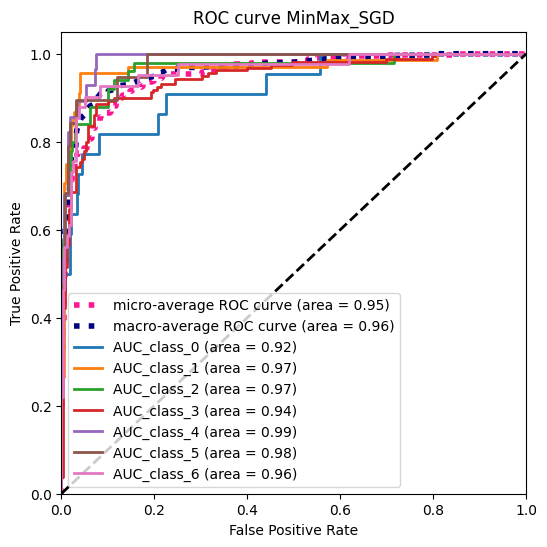

Evaluando modelo MinMax_SVCrbf (3/3)


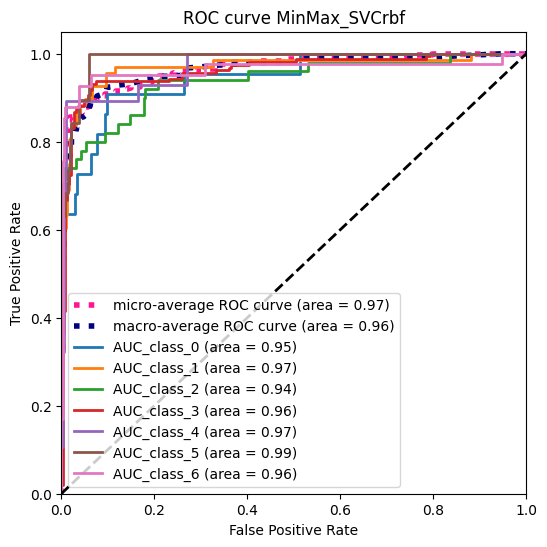

In [ ]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest)
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)


# **Ejercicio**

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1. Emplee optimización Bayesiana de hiperparámetros, fijando el score en términos del acc, el f1 y el AUC.


# **SOLUCION 1**
## **Modelos y Problemas de Optimización de Clasificadores**

A continuación, se presenta el modelo subyacente y el problema de optimización (o el principio de diseño) para los clasificadores solicitados, tal como se implementan comúnmente en librerías como `scikit-learn`.



### **1. Naive_Bayes.GaussianNB**

**Modelo:** Clasificador probabilístico basado en el Teorema de Bayes con independencia condicional entre características. Asume que las características siguen una distribución normal.

**Teorema de Bayes:**

$$
P(\text{clase} | \text{características}) \propto P(\text{clase}) \times \prod_{i=1}^{n} P(\text{característica}_i | \text{clase})
$$

**Distribución Normal:**

$$
P(x_i|y) = \frac{1}{\sqrt{2\pi\sigma_y^2}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma_y^2}\right)
$$

**Optimización:** No se utiliza una función de pérdida. Se estiman directamente $P(\text{clase})$ y $P(x_i|\text{clase})$ usando máxima verosimilitud.

---

### **2. SGDClassifier**

**Modelo:** Optimizador para modelos lineales como SVM, regresión logística, perceptrón.

**Función de decisión:**

$$
f(x) = w^T x + b
$$

**Problema de optimización general:**

$$
\min_{w,b} \frac{1}{n} \sum_{i=1}^{n} L(y_i, w^T x_i + b) + \alpha R(w)
$$

Donde $L$ es la función de pérdida (ej. hinge, log), $R(w)$ es regularización L1 o L2, y $\alpha$ su coeficiente.

**Algoritmo:** Descenso de Gradiente Estocástico (SGD).

---

### **3. LogisticRegression**

**Modelo:** Modelo lineal que estima la probabilidad de clase usando función sigmoide.

**Función de decisión:**

$$
P(Y=1|x) = \sigma(w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}
$$

**Función de pérdida (Log Loss):**

$$
\min_{w,b} -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\sigma(w^T x_i + b)) + (1 - y_i) \log(1 - \sigma(w^T x_i + b)) \right] + \alpha R(w)
$$

**Algoritmos:** Gradiente, L-BFGS, SAG, SAGA.

---

### **4. LinearDiscriminantAnalysis (LDA)**

**Modelo:** Clasificador lineal basado en proyecciones que maximizan la separación entre clases.

**Objetivo:**

$$
\max_w \frac{w^T S_B w}{w^T S_W w}
$$

**Ecuación de autovalores:**

$$
S_W^{-1} S_B w = \lambda w
$$

**Algoritmo:** Cálculo de autovalores y vectores propios.

---

### **5. KNeighborsClassifier (KNN)**

**Modelo:** Clasificador por instancia. Asigna la clase más común entre los k vecinos más cercanos.

**Distancia:** Euclidiana, Manhattan, etc.

**Optimización:** No hay entrenamiento. En predicción, se realiza búsqueda eficiente de vecinos (ej. KD-Tree).

---

### **6. LinearSVC**

**Modelo:** SVM lineal. Encuentra el hiperplano con el mayor margen.

**Función de decisión:**

$$
f(x) = w^T x + b
$$

**Función de pérdida (hinge loss):**

$$
\min_{w,b} \frac{1}{2} ||w||^2 + C \sum_{i=1}^{n} \max(0, 1 - y_i(w^T x_i + b))
$$

**Algoritmos:** Coordinate Descent, SGD.

---

### **7. SVC**

**Modelo:** SVM con kernel. Usa el truco del kernel para clasificaciones no lineales.

**Función de pérdida (problema dual):**

$$
\min_\alpha \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j y_i y_j K(x_i, x_j) - \sum_{i=1}^n \alpha_i
$$

**Sujeto a:** $0 \le \alpha_i \le C$ y $\sum_{i=1}^{n} \alpha_i y_i = 0$

**Algoritmo:** SMO (Sequential Minimal Optimization), QP.

---

###**8. RandomForestClassifier**

**Modelo:** Ensamble de árboles de decisión. Voto mayoritario.

**Principio:** Bagging + selección aleatoria de características (features).

Bagging (Bootstrap Aggregating):

Se crean múltiples muestras de entrenamiento mediante muestreo con reemplazo del conjunto de datos original. Para cada una de estas muestras, se entrena un árbol de decisión de forma independiente.

Selección aleatoria de características:

Al construir cada árbol, y específicamente al decidir cada división (split) en un nodo, no se consideran todas las características disponibles.

En su lugar, se selecciona un subconjunto aleatorio de características, y la mejor división se elige solo entre esas características seleccionadas.

Esto ayuda a reducir la varianza del modelo y a decorrelacionar los árboles, lo que generalmente mejora la precisión del ensamble.

En resumen, un RandomForestClassifier entrena muchos árboles de decisión, cada uno con una muestra ligeramente diferente de los datos y considerando solo un subconjunto aleatorio de características para realizar sus divisiones. Para hacer una predicción, cada árbol "vota" por una clase, y la clase con más votos se convierte en la predicción del modelo. Este enfoque lo hace robusto contra el sobreajuste (overfitting) y generalmente ofrece un buen rendimiento con poca necesidad de ajuste de hiperparámetros.


# **SOLUCION 2**
Clasificación multiclase - comparación de métodos utilizando validación cruzada

In [ ]:
!pip install scikit-optimize

In [ ]:
#librerias a importar
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import warnings

# Sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, f1_score
from sklearn.utils.multiclass import unique_labels
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import RocCurveDisplay # Add this line
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from time import time



# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

# Bayesian Optimization
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.preprocessing import LabelBinarizer

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)).
- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [ ]:
# Ignorar advertencias para una salida limpia
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
    os.mkdir('results')
except:
    print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    # Comentar esta línea si no estás en un entorno como Google Colab
    # from google.colab import files
    # files.download(path)

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(8,8)) # Aumentado el tamaño para mejor visualización
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = sns.color_palette("husl", n_classes) # Usar una paleta de colores diferente para más distinción
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.) # Ajustar leyenda para que no se superponga
    plt.grid(True)
    plt.show()
    # save_fig('results', title.replace(" ", "_") + "_ROC") # Para guardar la figura si es necesario


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100 * confusion_matrix(y_true, y_pred, normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots(figsize=(8, 6)) # Aumentar tamaño para mejor legibilidad
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    # save_fig('results', title.replace(" ", "_") + "_CM") # Para guardar la figura si es necesario
    return ax

Carpeta results ya existe


## **Lectura base de datos LFW**

- Se carga la base de datos desde los repositorios de sklearn.

Cargando base de datos LFW...
Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)
Número de clases: 7
Nombres de las clases: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


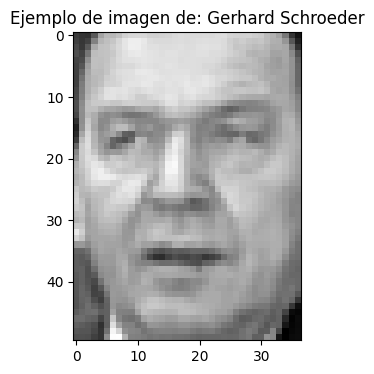

In [ ]:
#Lectura base de datos
print("Cargando base de datos LFW...")
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
target_names = lfw_people.target_names # Nombres de las clases para las matrices de confusión
n_classes_lfw = len(target_names) # Número de clases

print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
print(f"Número de clases: {n_classes_lfw}")
print(f"Nombres de las clases: {target_names}")

plt.figure(figsize=(4,4))
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                               lfw_people.images.shape[2]),cmap='gray')
plt.title(f"Ejemplo de imagen de: {target_names[y[300]]}")
plt.show()

## **HoldOut evaluación**

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.


Aquí es donde entra la validación cruzada con 5 folds:

- Cada vez que la Optimización Bayesiana decide un nuevo conjunto de hiperparámetros para evaluar, no los prueba solo en un único conjunto de validación. En cambio, realiza el siguiente procedimiento:

1. El conjunto de entrenamiento se divide en 5 subconjuntos (folds).

2. El modelo se entrena 5 veces.
En cada ronda, se usa un fold diferente como conjunto de validación y los 4 restantes como entrenamiento.

3. Se calcula una métrica de rendimiento (por ejemplo, accuracy) para cada una de esas 5 rondas.

4. El promedio de esas 5 puntuaciones de rendimiento es el valor que se le entrega a la Optimización Bayesiana.

In [ ]:
#Particion entrenamiento y evaluación
# Tamaño X_train 70%, Tamaño Xtest 30%
print("\nDividiendo datos en entrenamiento y prueba...")
X_train, X_test, y_train, y_test = train_test_split(Xdata, y, test_size=0.3, random_state=123, stratify=y)
print('Dimensiones X_train: ',X_train.shape)
print('Dimensiones y_train: ',y_train.shape)
print('Dimensiones Xtest: ',X_test.shape)
print('Dimensiones ytest: ',y_test.shape)
X_train.head() # Descomentar para ver las primeras filas


Dividiendo datos en entrenamiento y prueba...
Dimensiones X_train:  (901, 1850)
Dimensiones y_train:  (901,)
Dimensiones Xtest:  (387, 1850)
Dimensiones ytest:  (387,)


,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
1015,0.001630,0.001661,0.001804,0.001902,0.001938,0.001984,0.002127,0.002194,0.002230,0.002302,...,0.001625,0.001728,0.002886,0.003568,0.003440,0.003204,0.002804,0.001646,0.000543,0.000410
106,0.000779,0.001077,0.001440,0.001707,0.001938,0.002215,0.002445,0.002553,0.002599,0.002686,...,0.002481,0.002548,0.002676,0.003055,0.003583,0.003804,0.003865,0.003886,0.003870,0.003850
105,0.001235,0.001374,0.001651,0.001666,0.001507,0.001543,0.001640,0.001738,0.001835,0.001943,...,0.001061,0.001241,0.001282,0.001415,0.002850,0.003409,0.003148,0.003142,0.003199,0.003142
849,0.001543,0.001866,0.002466,0.002727,0.002722,0.002609,0.002543,0.002548,0.002604,0.002640,...,0.002502,0.002358,0.003081,0.003660,0.003706,0.003686,0.002030,0.000559,0.000769,0.000851
812,0.001087,0.001358,0.001692,0.002061,0.002235,0.002466,0.002650,0.002671,0.002691,0.002748,...,0.001405,0.001635,0.001297,0.000272,0.000349,0.000420,0.000492,0.000559,0.000651,0.000672


In [ ]:
# --- 3. Escalar las características ---
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(X_train)
Xtest_scaled = scaler.transform(X_test)
print("Características escaladas.")

Características escaladas.


 ## **PCA (Análisis de Componentes Principales)**

 Usamos PCA para:

- Acelerar el entrenamiento y la predicción de nuestros modelos.

- Reducir el riesgo de sobreajuste.

- Mejorar el rendimiento de algunos algoritmos que luchan con alta dimensionalidad.

- Extraer las características más relevantes y significativas de los datos de las caras.

En el caso específico del dataset LFW, donde cada "muestra" es una imagen de cara con cientos o miles de píxeles, PCA es una herramienta casi indispensable para preprocesar los datos y hacer que el problema sea manejable y los modelos más efectivos.

In [ ]:
# --- 4. Aplicar PCA para reducción de dimensionalidad ---
# Esta es la parte clave para reducir el costo computacional.
# n_components=0.95 significa que conservaremos el 95% de la varianza.
# Esto reduce el número de características de forma significativa.
print("\nAplicando PCA para reducción de dimensionalidad...")
pca = PCA(n_components=0.95, random_state=42)
Xtrain_pca = pca.fit_transform(Xtrain_scaled)
Xtest_pca = pca.transform(Xtest_scaled)

print(f"Dimensiones de los datos originales (escalados): {Xtrain_scaled.shape}")
print(f"Dimensiones de los datos después de PCA: {Xtrain_pca.shape}")
print(f"Número de componentes principales retenidos: {pca.n_components_}")

# A partir de ahora, las funciones objective_xxx y la evaluación final usarán Xtrain_pca y Xtest_pca.


Aplicando PCA para reducción de dimensionalidad...
Dimensiones de los datos originales (escalados): (901, 1850)
Dimensiones de los datos después de PCA: (901, 157)
Número de componentes principales retenidos: 157


## **Búsqueda de Parámetros con Optimización Bayesiana**

La Optimización Bayesiana es una estrategia inteligente para encontrar los mejores hiperparámetros para los modelos de machine learning.

**Nota**: Como en la Optimización Bayesiana se utiliza un enfoque guiado e inteligente para explorar el espacio de hiperparámetros, y ademas usando la validación cruzada (con 5 folds) se garantiza que la evaluación del rendimiento de cada combinación de hiperparámetros sea confiable y generalizable, llevando a encontrar los parámetros óptimos de manera más eficiente que otras técnicas.


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

Se Identifican los mejores hiperparámetros (por ejemplo, el C óptimo para SVM, el alpha para SGDClassifier, etc.) basándose en el rendimiento promedio de la validación cruzada en el conjunto de entrenamiento.

In [ ]:
# --- 5. Configuración de Optimización Bayesiana para cada modelo ---
# Diccionarios para almacenar los resultados y los pipelines de optimización
models_bo = {}
label_models_bo = []
best_scores_bo = {}
best_params_bo = {}

# Definimos el K-Fold Cross Validation (se mantiene con 5 folds)
cv_splits = 5
skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

print("\nConfigurando modelos para optimización Bayesiana (¡usando datos PCA!)...")

# --- Naive_Bayes.GaussianNB ---
name = 'GaussianNB'
label_models_bo.append(name)
space_gnb = [
    Real(1e-9, 1e-2, prior='log-uniform', name='var_smoothing')
]
@use_named_args(space_gnb)
def objective_gnb(var_smoothing):
    model = GaussianNB(var_smoothing=var_smoothing)
    # Usamos Xtrain_pca aquí
    scores = cross_val_score(model, Xtrain_pca, y_train, cv=skf,
                             scoring='accuracy',
                             n_jobs=-1)
    return -np.mean(scores)

print(f"Optimizando {name}...")
res_gnb = gp_minimize(objective_gnb, space_gnb, n_calls=20, n_initial_points=5, random_state=0, verbose=False)
models_bo[name] = res_gnb
best_scores_bo[name] = {'accuracy': -res_gnb.fun, 'f1_weighted': None, 'roc_auc_ovo': None}
best_params_bo[name] = res_gnb.x_iters[np.argmin(res_gnb.func_vals)]
print("Naive_Bayes.GaussianNB terminado.")


Configurando modelos para optimización Bayesiana (¡usando datos PCA!)...
Optimizando GaussianNB...
Naive_Bayes.GaussianNB terminado.


In [ ]:
# --- SGDClassifier ---
name = 'SGDClassifier'
label_models_bo.append(name)
space_sgd = [
    Real(1e-4, 1e-1, prior='log-uniform', name='alpha'),
    Categorical(['l1', 'l2', 'elasticnet'], name='penalty'),
    Integer(500, 3000, name='max_iter'),
    Categorical(['log_loss', 'hinge'], name='loss')
]
@use_named_args(space_sgd)
def objective_sgd(alpha, penalty, max_iter, loss):
    model = SGDClassifier(alpha=alpha, penalty=penalty, max_iter=max_iter, loss=loss, random_state=0, tol=1e-3)
    # Usamos Xtrain_pca aquí
    scores = cross_val_score(model, Xtrain_pca, y_train, cv=skf,
                             scoring='accuracy',
                             n_jobs=-1)
    return -np.mean(scores)

print(f"Optimizando {name}...")
res_sgd = gp_minimize(objective_sgd, space_sgd, n_calls=20, n_initial_points=5, random_state=0, verbose=False)
models_bo[name] = res_sgd
best_scores_bo[name] = {'accuracy': -res_sgd.fun, 'f1_weighted': None, 'roc_auc_ovo': None}
best_params_bo[name] = res_sgd.x_iters[np.argmin(res_sgd.func_vals)]
print("SGDClassifier terminado.")

Optimizando SGDClassifier...
SGDClassifier terminado.


In [ ]:
# --- LogisticRegression ---
name = 'LogisticRegression'
label_models_bo.append(name)
space_lr = [
    Real(1e-3, 1e3, prior='log-uniform', name='C'),
    Categorical(['l1', 'l2', 'elasticnet'], name='penalty'),
    Categorical(['liblinear', 'saga'], name='solver'),
    Real(0, 1, name='l1_ratio') # Añadido l1_ratio para elasticnet
]
@use_named_args(space_lr)
def objective_lr(C, penalty, solver, l1_ratio):
    # Ajustes para compatibilidad de solver y penalty
    if penalty == 'l1' and solver not in ['liblinear', 'saga']:
        solver = 'liblinear'
    elif penalty == 'elasticnet' and solver != 'saga':
        solver = 'saga'
    elif penalty == 'none' and solver not in ['lbfgs', 'newton-cg', 'sag', 'saga']:
        solver = 'lbfgs'

    # Pass l1_ratio to the model if penalty is elasticnet
    if penalty == 'elasticnet':
        model = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=0, max_iter=1000, l1_ratio=l1_ratio)
    else:
        model = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=0, max_iter=1000)

    # Usamos Xtrain_pca aquí (asumiendo que ya fue aplicado globalmente)
    scores = cross_val_score(model, Xtrain_pca, y_train, cv=skf, # y_train es la variable de etiquetas de entrenamiento
                             scoring='accuracy', # Solo 'accuracy' para la optimización
                             n_jobs=-1)
    return -np.mean(scores)

print(f"Optimizando {name}...")
# Reducción de n_calls y ajuste de n_initial_points
res_lr = gp_minimize(objective_lr, space_lr, n_calls=15, n_initial_points=5, random_state=0, verbose=False)
models_bo[name] = res_lr
best_scores_bo[name] = {'accuracy': -res_lr.fun, 'f1_weighted': None, 'roc_auc_ovo': None}
best_params_bo[name] = res_lr.x_iters[np.argmin(res_lr.func_vals)]
print("Optimización Bayesiana completada para LogisticRegression.")
print("LogisticRegression terminado.")

Optimizando LogisticRegression...


KeyboardInterrupt: 

In [ ]:
# --- LinearDiscriminantAnalysis ---
name = 'LinearDiscriminantAnalysis'
label_models_bo.append(name)
space_lda = [
    Categorical(['svd', 'lsqr', 'eigen'], name='solver'),
    Real(0.0, 1.0, name='shrinkage')
]
@use_named_args(space_lda)
def objective_lda(solver, shrinkage):
    if solver == 'svd':
        model = LinearDiscriminantAnalysis(solver=solver)
    else:
        model = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage)
    # Usamos Xtrain_pca aquí
    scores = cross_val_score(model, Xtrain_pca, y_train, cv=skf,
                             scoring='accuracy',
                             n_jobs=-1)
    return -np.mean(scores)

print(f"Optimizando {name}...")
res_lda = gp_minimize(objective_lda, space_lda, n_calls=30, n_initial_points=5, random_state=0, verbose=False)
models_bo[name] = res_lda
best_scores_bo[name] = {'accuracy': -res_lda.fun, 'f1_weighted': None, 'roc_auc_ovo': None}
best_params_bo[name] = res_lda.x_iters[np.argmin(res_lda.func_vals)]
print("LinearDiscriminantAnalysis terminado.")


Optimizando LinearDiscriminantAnalysis...
LinearDiscriminantAnalysis terminado.


In [ ]:
# --- KNeighborsClassifier ---
name = 'KNeighborsClassifier'
label_models_bo.append(name)
space_knn = [
    Integer(1, 20, name='n_neighbors'),
    Categorical(['uniform', 'distance'], name='weights'),
    Categorical(['auto', 'ball_tree', 'kd_tree', 'brute'], name='algorithm')
]
@use_named_args(space_knn)
def objective_knn(n_neighbors, weights, algorithm):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
    # Usamos Xtrain_pca aquí
    scores = cross_val_score(model, Xtrain_pca, y_train, cv=skf,
                             scoring='accuracy',
                             n_jobs=-1)
    return -np.mean(scores)

print(f"Optimizando {name}...")
res_knn = gp_minimize(objective_knn, space_knn, n_calls=30, n_initial_points=5, random_state=0, verbose=False)
models_bo[name] = res_knn
best_scores_bo[name] = {'accuracy': -res_knn.fun, 'f1_weighted': None, 'roc_auc_ovo': None}
best_params_bo[name] = res_knn.x_iters[np.argmin(res_knn.func_vals)]
print("KNeighborsClassifier terminado.")

Optimizando KNeighborsClassifier...
KNeighborsClassifier terminado.


In [ ]:
# --- LinearSVC ---
name = 'LinearSVC'
label_models_bo.append(name)
space_linear_svc = [
    Real(1e-3, 1e3, prior='log-uniform', name='C'),
    Categorical(['l1', 'l2'], name='penalty'),
    Categorical(['hinge', 'squared_hinge'], name='loss')
]
@use_named_args(space_linear_svc)
def objective_linear_svc(C, penalty, loss):
    # Corrección para la compatibilidad de penalty y loss
    if penalty == 'l1':
        # 'l1' penalty solo es compatible con 'squared_hinge' loss cuando dual=False
        loss = 'squared_hinge'
    elif penalty == 'l2' and loss == 'hinge':
        # 'l2' penalty con 'hinge' loss NO es compatible cuando dual=False
        # Debemos cambiar 'hinge' a 'squared_hinge' para 'l2' cuando dual=False
        loss = 'squared_hinge'

    # dual=False es importante para cuando n_samples > n_features, o si n_features es grande como aquí
    # (Lo cual es el caso después de PCA en LFW, donde n_components < n_samples)
    model = LinearSVC(C=C, penalty=penalty, loss=loss, random_state=0, max_iter=2000, dual=False)

    # Usamos Xtrain_pca aquí
    scores = cross_val_score(model, Xtrain_pca, y_train, cv=skf,
                             scoring='accuracy',
                             n_jobs=-1)
    return -np.mean(scores)

print(f"Optimizando {name}...")
res_linear_svc = gp_minimize(objective_linear_svc, space_linear_svc, n_calls=20, n_initial_points=5, random_state=0, verbose=False)
models_bo[name] = res_linear_svc
best_scores_bo[name] = {'accuracy': -res_linear_svc.fun, 'f1_weighted': None, 'roc_auc_ovo': "N/A"} # No AUC para LinearSVC directo sin prob
best_params_bo[name] = res_linear_svc.x_iters[np.argmin(res_linear_svc.func_vals)]
print("LinearSVC terminado.")

Optimizando LinearSVC...


KeyboardInterrupt: 

In [ ]:
# --- SVC (kernel='rbf' por defecto, pero se puede probar otros) ---
name = 'SVC'
label_models_bo.append(name)
space_svc = [
    Real(1e-3, 1e3, prior='log-uniform', name='C'),
    Real(1e-6, 1e1, prior='log-uniform', name='gamma'),
    Categorical(['rbf', 'poly', 'sigmoid'], name='kernel'),
    Integer(2, 5, name='degree') # Solo para kernel='poly'
]
@use_named_args(space_svc)
def objective_svc(C, gamma, kernel, degree):
    if kernel == 'poly':
        model = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, random_state=0, probability=True)
    else:
        model = SVC(C=C, gamma=gamma, kernel=kernel, random_state=0, probability=True) # probability=True para predict_proba para AUC
    # Usamos Xtrain_pca aquí
    scores = cross_val_score(model, Xtrain_pca, y_train, cv=skf,
                             scoring='accuracy',
                             n_jobs=-1)
    return -np.mean(scores)

print(f"Optimizando {name}...")
res_svc = gp_minimize(objective_svc, space_svc, n_calls=20, n_initial_points=5, random_state=0, verbose=False)
models_bo[name] = res_svc
best_scores_bo[name] = {'accuracy': -res_svc.fun, 'f1_weighted': None, 'roc_auc_ovo': None}
best_params_bo[name] = res_svc.x_iters[np.argmin(res_svc.func_vals)]
print("SVC terminado.")

Optimizando SVC...
SVC terminado.


In [ ]:
# --- RandomForestClassifier ---
name = 'RandomForestClassifier'
label_models_bo.append(name)
space_rf = [
    Integer(10, 200, name='n_estimators'),
    Integer(2, 20, name='max_depth'),
    Real(0.01, 1.0, prior='log-uniform', name='min_samples_leaf'),
    Categorical(['gini', 'entropy'], name='criterion')
]
@use_named_args(space_rf)
def objective_rf(n_estimators, max_depth, min_samples_leaf, criterion):
    if min_samples_leaf < 1:
        msl = min_samples_leaf
    else:
        msl = int(min_samples_leaf)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_leaf=msl, criterion=criterion, random_state=0)
    # Usamos Xtrain_pca aquí
    scores = cross_val_score(model, Xtrain_pca, y_train, cv=skf,
                             scoring='accuracy',
                             n_jobs=-1)
    return -np.mean(scores)

print(f"Optimizando {name}...")
res_rf = gp_minimize(objective_rf, space_rf, n_calls=20, n_initial_points=5, random_state=0, verbose=False)
models_bo[name] = res_rf
best_scores_bo[name] = {'accuracy': -res_rf.fun, 'f1_weighted': None, 'roc_auc_ovo': None}
best_params_bo[name] = res_rf.x_iters[np.argmin(res_rf.func_vals)]
print("RandomForestClassifier terminado.")

print("\nOptimización Bayesiana completada para todos los modelos.")

Optimizando RandomForestClassifier...
RandomForestClassifier terminado.

Optimización Bayesiana completada para todos los modelos.


## **Reentrenamiento Final y rendimiento en cojunto de test:**
Una vez que tenemos esos hiperparámetros "ganadores", tomamos el modelo con esos parámetros y lo entrenamos una última vez usando todos los datos de entrenamiento (Xtrain_pca). Esto permite que el modelo aprenda de la mayor cantidad de información posible antes de ser evaluado en el conjunto de prueba nunca antes visto (Xtest_pca).

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acc, el f1 y el AUC.



In [ ]:
# --- 6. Reentrenar los mejores modelos con los hiperparámetros óptimos y evaluar en el conjunto de prueba ---
print("\nReentrenando los mejores modelos y evaluando en el conjunto de prueba...")
final_models = {}

for name in label_models_bo:
    print(f"\nEvaluando {name}...")
    best_params = best_params_bo[name]

    if name == 'GaussianNB':
        final_model = GaussianNB(var_smoothing=best_params[0])
    elif name == 'SGDClassifier':
        final_model = SGDClassifier(alpha=best_params[0], penalty=best_params[1],
                                    max_iter=best_params[2], loss=best_params[3],
                                    random_state=0, tol=1e-3)
    elif name == 'LogisticRegression':
        C, penalty, solver, l1_ratio = best_params
        if penalty == 'elasticnet':
            final_model = LogisticRegression(C=C, penalty=penalty, solver=solver,
                                             random_state=0, max_iter=1000, l1_ratio=l1_ratio)
        else:
            final_model = LogisticRegression(C=C, penalty=penalty, solver=solver,
                                             random_state=0, max_iter=1000)
    elif name == 'LinearDiscriminantAnalysis':
        solver, shrinkage = best_params
        if solver == 'svd':
            final_model = LinearDiscriminantAnalysis(solver=solver)
        else:
            final_model = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage)
    elif name == 'KNeighborsClassifier':
        n_neighbors, weights, algorithm = best_params
        final_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
    elif name == 'LinearSVC':
        C, penalty, loss = best_params
        if penalty == 'l1' and loss != 'squared_hinge':
            loss = 'squared_hinge'
        final_model = LinearSVC(C=C, penalty=penalty, loss=loss, random_state=0, max_iter=2000, dual=False)
    elif name == 'SVC':
        C, gamma, kernel, degree = best_params
        if kernel == 'poly':
            final_model = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, random_state=0, probability=True)
        else:
            final_model = SVC(C=C, gamma=gamma, kernel=kernel, random_state=0, probability=True)
    elif name == 'RandomForestClassifier':
        n_estimators, max_depth, min_samples_leaf, criterion = best_params
        if min_samples_leaf < 1:
            msl = min_samples_leaf
        else:
            msl = int(min_samples_leaf)
        final_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                            min_samples_leaf=msl, criterion=criterion, random_state=0)
    else:
        raise ValueError(f"Modelo {name} no reconocido.")

    start_time = time()
    final_model.fit(Xtrain_pca, y_train)
    end_time = time()
    training_time = end_time - start_time
    print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

    final_models[name] = final_model

    y_pred = final_model.predict(Xtest_pca)

    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    best_scores_bo[name]['accuracy'] = accuracy
    best_scores_bo[name]['f1_weighted'] = f1_weighted

    if hasattr(final_model, "predict_proba"):
        try:
            y_score = final_model.predict_proba(Xtest_pca)
            roc_auc_ovo = roc_auc_score(y_test, y_score, multi_class='ovo', average='weighted')
            best_scores_bo[name]['roc_auc_ovo'] = roc_auc_ovo
        except Exception as e:
            print(f"Advertencia: No se pudo calcular ROC AUC para {name}: {e}")
            best_scores_bo[name]['roc_auc_ovo'] = "Error"
    elif hasattr(final_model, "decision_function") and name == 'LinearSVC':
        best_scores_bo[name]['roc_auc_ovo'] = "N/A (decision_function)"
    else:
        best_scores_bo[name]['roc_auc_ovo'] = "N/A"

    print(f"  Accuracy en test: {accuracy:.4f}")
    print(f"  F1-weighted en test: {f1_weighted:.4f}")
    print(f"  ROC AUC (OvO) en test: {best_scores_bo[name]['roc_auc_ovo']:.4f}" if isinstance(best_scores_bo[name]['roc_auc_ovo'], float) else f"  ROC AUC (OvO) en test: {best_scores_bo[name]['roc_auc_ovo']}")

    # --- Mostrar la matriz de confusión aquí ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 7)) # Ajusta el tamaño para que sea legible
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Matriz de Confusión para {name}\nAccuracy: {accuracy:.2f}, F1: {f1_weighted:.2f}')
    plt.xlabel('Clase Predicha')
    plt.ylabel('Clase Verdadera')
    plt.show() # ¡Importante para que se muestre cada gráfico!


## **Resultados de Optimización de hiperparámetros (validación cruzada) y evaluación final en el conjunto de prueba.**

se muestran los resultados de :
- Qué tan bien se desempeñó cada modelo con su configuración óptima de hiperparámetros durante el proceso de ajuste (Best Accuracy (CV)).

- Cuál fue su rendimiento real y generalizable en datos completamente nuevos (Best F1-weighted (Test), Best ROC AUC (OvO) (Test)).

- Cuáles fueron los hiperparámetros específicos que condujeron a ese mejor rendimiento (Best Params).

In [ ]:
# --- 7. Mostrar resultados de la optimización Bayesiana ---
print("\n--- Resultados de la Optimización Bayesiana y Evaluación Final ---")
results_df_bo = pd.DataFrame(columns=['Model', 'Best Accuracy (CV)', 'Best F1-weighted (Test)', 'Best ROC AUC (OvO) (Test)', 'Best Params'])

for name in label_models_bo:
    best_accuracy_cv = -models_bo[name].fun # El mejor accuracy encontrado durante la CV
    best_f1_test = best_scores_bo[name]['f1_weighted']
    best_roc_auc_test = best_scores_bo[name]['roc_auc_ovo']
    params = best_params_bo[name]

    # Convertir los parámetros de vuelta a un diccionario con nombres claros para mostrar
    param_names = [s.name for s in models_bo[name].space]
    best_params_dict = dict(zip(param_names, params))

    results_df_bo.loc[len(results_df_bo)] = [
        name,
        f"{best_accuracy_cv:.4f}",
        f"{best_f1_test:.4f}" if isinstance(best_f1_test, float) else best_f1_test,
        f"{best_roc_auc_test:.4f}" if isinstance(best_roc_auc_test, float) else best_roc_auc_test,
        best_params_dict
    ]

print(results_df_bo.to_string())

# --- 8. Comparación gráfica de los resultados de rendimiento ---
print("\n--- Comparación Gráfica de Rendimiento ---")

# Filter out models with non-numeric ROC AUC for plotting that specific metric
model_names_plot = [name for name, score in best_scores_bo.items() if isinstance(score['accuracy'], float)] # Assuming accuracy is always float

metrics_to_plot = {
    'Accuracy': [best_scores_bo[name]['accuracy'] for name in model_names_plot],
    'F1-weighted': [best_scores_bo[name]['f1_weighted'] for name in model_names_plot],
    'ROC AUC (OvO)': [best_scores_bo[name]['roc_auc_ovo'] for name in model_names_plot if isinstance(best_scores_bo[name]['roc_auc_ovo'], float)]
}

# Adjust model names for ROC AUC plotting
model_names_roc_auc = [name for name in model_names_plot if isinstance(best_scores_bo[name]['roc_auc_ovo'], float)]


if not model_names_plot:
    print("No hay modelos con resultados numéricos para graficar.")
else:
    plt.figure(figsize=(12, 6))
    x = np.arange(len(model_names_plot))
    width = 0.2

    # Plot Accuracy and F1-weighted for all models
    plt.bar(x - width, metrics_to_plot['Accuracy'], width, label='Accuracy')
    plt.bar(x, metrics_to_plot['F1-weighted'], width, label='F1-weighted')

    # Plot ROC AUC only for models with numerical values
    if metrics_to_plot['ROC AUC (OvO)']: # Check if there are any numerical ROC AUC values
        plt.bar(x[np.isin(model_names_plot, model_names_roc_auc)] + width, metrics_to_plot['ROC AUC (OvO)'], width, label='ROC AUC (OvO)')


    plt.xlabel('Modelo')
    plt.ylabel('Puntuación')
    plt.title('Rendimiento de los Modelos (Evaluación Final en Test Set con PCA)')
    plt.xticks(x, model_names_plot, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## **Curva ROC multiclase - sobre conjunto de test**

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

In [ ]:
# --- 9. ROC Curves for Best Models (Multi-class - One-vs-Rest) ---
print("\n--- Generating ROC Curves (One-vs-Rest) ---")

# --- Placeholder for custom_roc_multiclass_metrics if not defined elsewhere ---
def custom_roc_multiclass_metrics(y_true_binarized, y_score, n_classes_total):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes_total):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return roc_auc, fpr, tpr, n_classes_total

# --- Placeholder for custom_roc_auc_mc_plot (now integrated per model) ---
# This function is not strictly needed as a separate function if plotting logic is embedded.

# Binarize labels for One-vs-Rest approach
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
n_classes_roc = y_test_binarized.shape[1]

has_roc_models = False # Flag to check if any ROC curves were plotted

for name, model in final_models.items():
    print(f"Generating ROC curves for {name}...")

    # LinearSVC does not support predict_proba directly for ROC curves
    if hasattr(model, "predict_proba"):
        try:
            y_score = model.predict_proba(Xtest_pca)

            # Use your custom roc_multiclass function
            roc_auc_dict, fpr_dict, tpr_dict, _ = custom_roc_multiclass_metrics(
                y_test_binarized, y_score, n_classes_roc
            )

            # --- Create a NEW figure for EACH model ---
            plt.figure(figsize=(10, 8)) # Adjust size as needed for individual plots
            ax = plt.gca() # Get the current axes for this new figure
            colors = plt.cm.get_cmap('tab10', n_classes_roc) # Get a colormap for classes within this model's plot

            for i in range(n_classes_roc):
                ax.plot(fpr_dict[i], tpr_dict[i], color=colors(i),
                        label=f'ROC curve for {lb.classes_[i]} (area = {roc_auc_dict[i]:0.2f})',
                        alpha=0.8) # Alpha for individual class curves

            # --- Add common plot elements for THIS model's figure ---
            ax.plot([0, 1], [0, 1], 'k--', label='Chance level (area = 0.5)')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'ROC Curves (One-vs-Rest) for {name} on Test Set with PCA')
            ax.legend(loc="lower right", fontsize='small')
            ax.grid(linestyle='--', alpha=0.6)
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            plt.tight_layout()
            plt.show() # Display this specific model's plot

            has_roc_models = True
        except Exception as e:
            print(f"  Could not generate ROC curve for {name}: {e}")
    else:
        print(f"  Model {name} does not support predict_proba for ROC curves.")

if not has_roc_models:
    print("No ROC curves were generated for any model.")